In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.layers import  Conv1D, MaxPooling1D
from keras.models import Model, Sequential

from keras import initializers, regularizers, constraints, optimizers, layers

In [137]:
data = pd.read_csv('cleaned.1600000.tweets.csv')
data.head()

,Unnamed: 0,text,new_target
0,509846,morning strict orders feet knit mind body feel...,Negative
1,602894,emorethan,Negative
2,1384873,hacking cool tetris th birthday today yay some...,Positive
3,874947,hey climb debuted vh top countdown congrads,Positive
4,458741,new post tomorrow breastfeeding journey ending,Negative


In [138]:
data.shape

(1600000, 3)

In [139]:
data.drop('Unnamed: 0', axis = 1, inplace = True)

In [140]:
data.dropna(axis = 0, inplace = True)

In [141]:
data['target'] = data['new_target'].apply(lambda x : 0 if x == 'Negative' else 1)

In [142]:
data.head()

,text,new_target,target
0,morning strict orders feet knit mind body feel...,Negative,0
1,emorethan,Negative,0
2,hacking cool tetris th birthday today yay some...,Positive,1
3,hey climb debuted vh top countdown congrads,Positive,1
4,new post tomorrow breastfeeding journey ending,Negative,0


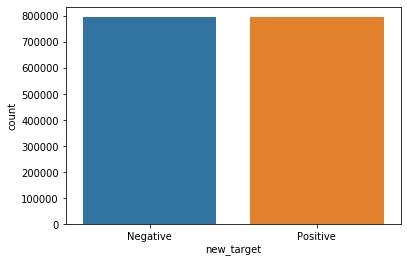

In [143]:
sns.countplot(data['new_target'])
plt.show()

In [144]:
X = data['text'][:300000]
y = data['target'][:300000]

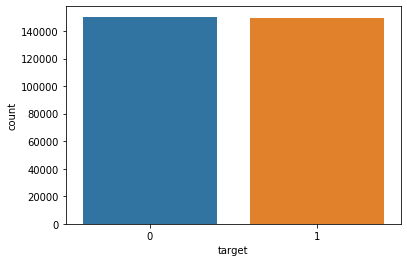

In [145]:
sns.countplot(y)
plt.show()

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)
print(X_train.shape, X_test.shape)

(240000,) (60000,)


### Model Building

#### Fitting LSTM with Embedding layer

In [147]:
vocab_size = 300000
tokenizer = Tokenizer(num_words = vocab_size)

tokenizer.fit_on_texts(X_train)

list_tokenized_train = tokenizer.texts_to_sequences(X_train)

max_review_len = 40
X_train = pad_sequences(list_tokenized_train, maxlen = max_review_len, padding = 'post')


In [148]:
print(X_train.shape, y_train.shape)

(240000, 40) (240000,)


In [149]:
X_train[:2]

array([[  68, 8218,  494,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [  45,   17,    4,    5,   14,   46,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]])

In [150]:
y_train[:2]

255472    1
53743     0
Name: target, dtype: int64

In [151]:
model = Sequential()

model.add(Embedding(vocab_size, 32, input_length = 40))

model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=64, kernel_size=6, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=32, kernel_size=8, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 40, 32)            9600000   
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 40, 128)           20608     
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 20, 128)           0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 20, 128)           0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 20, 64)            49216     
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 10, 64)            0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 10, 64)           

In [152]:
history = model.fit(X_train, y_train, batch_size = 32, verbose = 1, validation_split =  0.2, epochs = 2 )

C:\My_Programs\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 192000 samples, validate on 48000 samples
Epoch 1/2
192000/192000 [==============================] - 256s 1ms/step - loss: 0.5048 - accuracy: 0.7515 - val_loss: 0.4714 - val_accuracy: 0.7737
Epoch 2/2
192000/192000 [==============================] - 256s 1ms/step - loss: 0.4192 - accuracy: 0.8092 - val_loss: 0.4770 - val_accuracy: 0.7731


In [153]:
list_tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(list_tokenized_test, maxlen = max_review_len)


In [154]:
# Prediction 
prediction = model.predict(X_test)

In [155]:
y_pred = (prediction > 0.5)
y_pred[:2]

array([[False],
       [ True]])

In [156]:
# Evaluation
print('Model Accuracy : ', accuracy_score(y_test, y_pred))
print("F1 Score : ", f1_score(y_test, y_pred))
print("Confusion_Matrix" , '\n', confusion_matrix(y_test, y_pred))


Model Accuracy :  0.4461833333333333
F1 Score :  0.6079867869993512
Confusion_Matrix 
 [[ 1003 29146]
 [ 4083 25768]]


Thanks
reference
https://www.kaggle.com/